# Interactive dEB light curve viewing tool

In [1]:
from pathlib import Path
import re
from itertools import zip_longest
from copy import deepcopy

import numpy as np
import astropy.units as u
from astropy.time import Time
import lightkurve as lk

#%matplotlib widget 
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *

from libs.lightcurves import load_lightcurves, create_invalid_flux_mask
from libs.lightcurves import append_magnitude_columns, find_lightcurve_segments, fit_polynomial

#### Select your target
The `target` is the object name value used on plots, messages and local cache folder.
The `search_term` is used to search for assets in MAST, which can be object name
(with or without a V* prefix) or a TIC identifier (9 digit numeric value).

In [2]:
default_target = "CW Eri"
display(HBox(children=[
    (target_text := Text(description="target :", value=default_target, placeholder="target name or TIC number")),
    (do_prefix := Checkbox(description="prefix search term with V* unless TIC", value=True, layout={'width': "max-content"} )),
]))

In [3]:
target = f"TIC {int(target_text.value):09d}" if target_text.value.isnumeric() else target_text.value
search_term = f"V* {target}" if not target.startswith("TIC") and do_prefix.value else target

#### Review Target Information and refine the search

In [4]:
# Find any assets for the target, filtered on TESS timeseries observations
results = lk.search_lightcurve(search_term)
suitability_mask = ((results.author == "SPOC") | (results.author == "TESS-SPOC")) \
                    & (results.table["dataproduct_type_products"] == "timeseries") \
                    & (results.table["obs_collection_products"] != "HLSP") \
                    & np.where(["TESS" in m for m in results.mission], True, False)

fmt = "{0} ({1}, mission={2}, author={3}, target={4}, exptime={5})"
display(VBox(children=(checkboxes := [
    Checkbox(description=fmt.format(r.mission[0], r.year[0], r.table["obs_collection_products"][0], r.author[0], r.target_name[0], r.exptime[0]),
             value=True, layout={'width': "max-content"}) for r in results[suitability_mask]
])))

#### Download the light curves of the chosen sectors
For details of the flux_column and quality_bitmask arguments see the documentation for
[download](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.SearchResult.download.html#lightkurve.SearchResult.download).
The find_lightcurves() function will attempt to service the request from the
local cache in preference to contacting MAST.

In [5]:
display(HBox(children=[
    (flux_column     := widgets.Dropdown(options=["sap_flux", "pdcsap_flux"], value="sap_flux", description="flux_column :", style={'description_width': 'max-content'})),
    (quality_bitmask := widgets.Dropdown(options=["default", "hard", "hardest"], value="default", description="quality_bitmask :", style={'description_width': 'max-content'})),
]))

In [6]:
select_mask = np.array([checkboxes[i].value for i in range(len(checkboxes))], dtype=bool)
lcs = load_lightcurves(results[suitability_mask][select_mask], quality_bitmask.value, flux_column.value,
                       Path.cwd() / ".cache" / re.sub(r"[^\w\d]", "-", target.lower()))

#### Plot the selected light curves

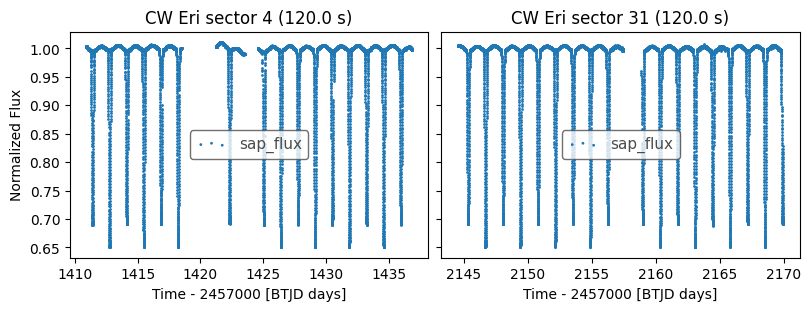

In [7]:
rows = int(np.ceil(len(lcs) / (cols := 2)))
fig, axes = plt.subplots(rows, cols, figsize=(8, 3*rows), sharey=True, constrained_layout=True)
axes = [axes] if isinstance(axes, Axes) else axes.flatten()

for ix, (ax, lc) in enumerate(zip_longest(axes, lcs)):
    if ix < len(lcs):
        lc.scatter(ax=ax, label=f"{lc.meta['FLUX_ORIGIN']}", normalize=True)
        ax.set_ylabel(None if ix % cols else ax.get_ylabel())
        ax.set_title(f"{target} sector {lc.meta['SECTOR']} ({lc.meta['FRAMETIM']*lc.meta['NUM_FRM'] * u.s})")
    else:
        ax.axis("off")
plt.show()
plt.close(fig) # Comment this out if using %matplotlib widget to enable interactive plot

#### Process the light curves to create flattened copies with delta_mag columns
Here we have an opportunity to create masks to exclude distorted regions.
There's currently no interactive tool for this, so the easiest approach is to
create masks from time criteria. For example;
```python
# Select only datapoints outide the range 1420 to 1424 (btjd)
mask = (lcs[0].time <= Time(1420, format="btjd", scale="tdb")) | (lcs[0].time >= Time(1424, format="btjd", scale="tdb"))
```

In [8]:
# Mask out any datapoints with flux of NaN or < 0
mask_lcs = lk.LightCurveCollection([
    lc[create_invalid_flux_mask(lc) & ((lc.time <= Time(1420, format="btjd", scale="tdb")) | (lc.time >= Time(1424, format="btjd", scale="tdb")))] for lc in lcs
])

In [9]:
for lc in mask_lcs:
    # Create detrended & rectified delta_mag and delta_mag err columns
    append_magnitude_columns(lc, "delta_mag", "delta_mag_err")
    detrend_ranges = [*find_lightcurve_segments(lc, threshold=2.0, return_times=True)]
    for detrend_range in detrend_ranges:
        dmask = (lc.time >= np.min(detrend_range)) & (lc.time <= np.max(detrend_range))
        lc["delta_mag"][dmask] -= fit_polynomial(lc.time[dmask], lc["delta_mag"][dmask], degree=2,
                                                 iterations=2, res_sigma_clip=1.0, verbose=True)


	Generated polynomial; y = poly(x, c0=-1.243222e+01, c1=6.386496e-05, c2=5.929817e-04) (sigma(fit_ydata)=2.556833e-03 mag)
	Generated polynomial; y = poly(x, c0=-1.243060e+01, c1=-2.427283e-04, c2=4.898392e-05) (sigma(fit_ydata)=1.023256e-03 mag)
	Generated polynomial; y = poly(x, c0=-1.243297e+01, c1=5.098184e-05, c2=-6.107058e-07) (sigma(fit_ydata)=3.792564e-04 mag)


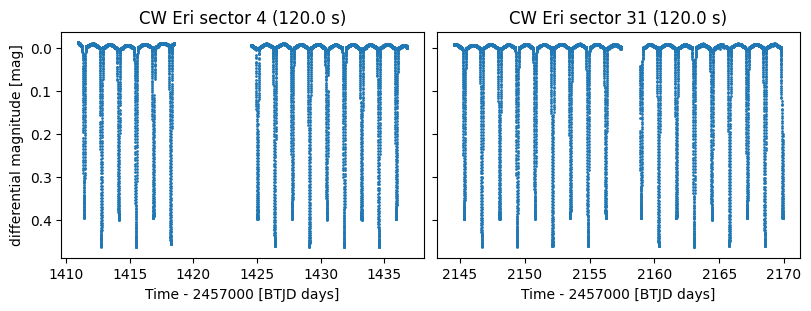

In [10]:
rows = int(np.ceil(len(lcs) / (cols := 2)))
fig, axes = plt.subplots(rows, cols, figsize=(8, 3*rows), sharey=True, constrained_layout=True)
axes = [axes] if isinstance(axes, Axes) else axes.flatten()

for ix, (ax, lc) in enumerate(zip_longest(axes, mask_lcs)):
    if ix < len(lcs):
        lc.scatter(ax=ax, column="delta_mag", label=None)
        ax.set_ylabel(None if ix % cols else "differential magnitude [mag]")
        ax.set_title(f"{target} sector {lc.meta['SECTOR']} ({lc.meta['FRAMETIM']*lc.meta['NUM_FRM'] * u.s})")
        if ix == 0:
            ax.invert_yaxis()
    else:
        ax.axis("off")
plt.show()
plt.close(fig) # Comment this out if using %matplotlib widget to enable interactive plot